# Global indicator project
## Get and save study region walkable street network, load OSM basic network and stats

This notebook describes functions to get street networks from OpenStreetMap (OSM) using OSMnx, a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API. This notebook retrieve functions at ```01_create_studyregion``` to obtain OSM network and basic stats based on study region buffer polygon. The network data are saved to local data folder.   

All the functions are stored in ```setup_OSMnetwork.py```, and imported in this notebook to produce outcome. Study region parameters are in ```config.py```.

** Define projection for each area: study region files are projected to lat-lng for consistency, and to the local UTM projection when needed for meter-based calculations.


In [1]:
#load local OSM python module
from setup_OSMnetwork import *
#load project configeration
from config import *


## Get pedestrain street network and save to local folder

In [ ]:
start = time.time()
task = "Create study region polygon, save street network graphml (lat-long)"
polygon_buffer = get_bufferedstudyregion_polygon(boundary_filepath, buffer_dist=1e4, crs=crs, to_crs=to_crs, to_latlong=True)
Save_OSM_G(polygon_buffer[0], network_type= 'walk', placename=placename, suffix=suffix, folder=OSM_folder)
print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 


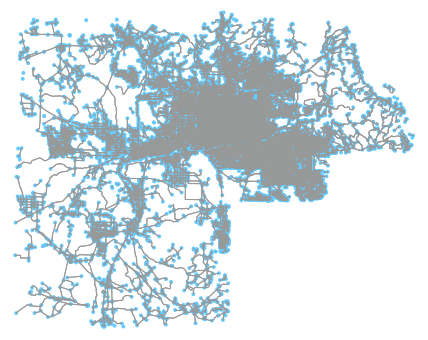

Completed task "save projected street network graphml (UTM) from a graphml" in 40,616.60 seconds


In [7]:
start = time.time()
task = "save projected street network graphml (UTM) from a graphml"
Save_OSM_G_proj(placename=placename, network_type= 'walk', suffix=suffix, folder=OSM_folder, to_crs=None)
print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 


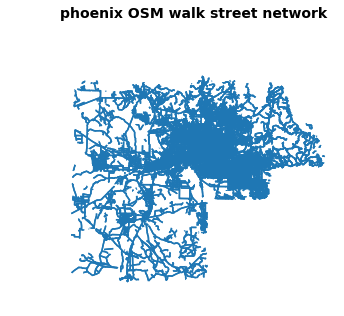

Completed task "save projected street network geodataframe (UTM) from a projected graphml" in 1,207.27 seconds


In [8]:
start = time.time()
task = "save projected street network geodataframe (UTM) from a projected graphml"
Save_OSM_gdf_proj(placename=placename, network_type= 'walk', suffix=suffix, folder=OSM_folder)
print('Completed task "{}" in {:,.2f} seconds'.format(task, time.time() - start)) 


## Load pedestrain street network from local folder

In [3]:
# get OSM pedestrain network graphml
G = get_OSM_G(G_filename, OSM_folder, polygon=None, network_type= 'walk')

In [4]:
# get OSM pedestrain network shapefile
gdf = get_OSM_edges_gdf(OSM_shapefile_path, OSM_folder, polygon=None, network_type= 'walk')

## Load OSM network stats
This function retains all the basic stats for all streets, pedestrain network, and cycle network within 10km buffered study regions. The OSM street network data are loaded from local data folder. 

In [4]:
start = time.time()
task = "load street network basic stats"
df = load_OSM_basic_stats(G_filename, folder=OSM_folder)
print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 

df

Completed task "load street network basic stats" in 509.94 seconds


,OSM_pedestrain_network
n,387620
m,1094578
k_avg,5.64769
intersection_count,326214
streets_per_node_avg,2.82446
streets_per_node_counts,"{0: 1, 1: 61405, 2: 6147, 3: 261532, 4: 56292,..."
streets_per_node_proportion,"{0: 2.5798462411640264e-06, 1: 0.1584154584386..."
edge_length_total,1.2913e+08
edge_length_avg,117.973
street_length_total,6.51782e+07
